<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 4: Reinforcement Learning</H2>

| Date set     | Hand-in date |
|:------------------|:-----------------------------------|
| 6th March 2020  | **  Wednesday 18th March ** |


<b> Student Number: 660022200 </b>

This workshop is worth 25% of the total module mark.





Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>


<div class="alert alert-info">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
</div>


In [144]:
# including libraries as usual
import matplotlib.pyplot as plt
import numpy as np


# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 


In [145]:
class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-100):
        '''
        Generates a new Gridworld problem, with a grid of size (width,height). 
        gamma: reward discoount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0,0])
        goal: goal location (default: [0,0])
        cliff: list of locations defined as cliff (the agent incurs a large penalty for walking into cliffs and is transported back to the start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''
        # define the four possible actions
        self.gamma = gamma
        self.actions = range(4)
        self.delta = np.array([[0,-1],[+1,0],[0,+1],[-1,0]])
        self.actions_labels = ['up','right','down','left']
        
        self.states = range(width*height)

        self.width = width
        self.height = height
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        self.goal = self.encode_state(goal)
        self.penalty = penalty
        self.cliff_penalty = cliff_penalty
        self.grid = np.zeros((height,width))
        for c in range(width): 
            for r in range(height): 
                if [c,r] == goal: 
                    self.grid[r,c] = 1
                elif [c,r] in cliff: 
                    self.grid[r,c] = 2
                elif [c,r] == start: 
                    self.grid[r,c] = 3
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = 'Grid world:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                elif self.grid[r,c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    def print_solution(self,S): 
        '''
        Graphical display of a solution S, given as a list of states that brings from the initial state to the goal. 
        '''
        s = 'Solution:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c,r))                
                
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print( np.array(self.states).reshape((self.width,self.height)).T )
    
    def encode_state(self,coord):
        '''
        Converts a tuple (c,r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c,r) = coord
        if r<self.height and c<self.width and r>=0 and c>=0: 
            return int(c*self.height+r)
        else: 
            return -1
    
    def decode_state(self,s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return (s//self.height,s%self.height)
        
    def state_action_state(self,s,a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        
        ns = self.encode_state(self.decode_state(s) + self.delta[a,:])
        
        if ns in self.cliff: 
            return [(self.start, self.cliff_penalty)]
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return [(s,self.penalty)]
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return [(ns,0)]
        
        else: 
            return [(ns,self.penalty)]
        
    def state_transition(self,s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv,pv,rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(len(self.actions),dtype='uint')
        pv = np.zeros(len(self.actions))
        rv = np.zeros(len(self.actions))
        
        for a in self.actions: 
            (s2,r2) = self.state_action_state(s,a)[0]
            sv[a] = s2
            pv[a] = 1.0/len(self.actions)
            rv[a] = r2
            
        return (sv,rv,pv)
            
world = GridWorld(6,4, gamma=0.9, goal=[5,3], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])
print( world.tostring() )

print('GridWorld state indexing:')
print(world.grid)

Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

GridWorld state indexing:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [3. 2. 2. 2. 2. 1.]]


## 1. Policy evaluation

One simple way to solve a reinforcement learning problem is to estimate the value function for the whole problem and then apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using <b>policy iteration</b>, as discussed in class. 
Iterative policy evaluation proposes an update of the value function based on the recursive formulation of the <i>Bellman equation</i>: 

$$
V^{(t+1)}(S_t) \leftarrow \sum_{S_{t+1},R_{t+1}} p\left[S_{t+1},R_{t+1}|S_t,\pi(S_t)\right] \left(R_{t+1}+\gamma V^{t}(S_{t+1})\right)
$$

In this part, you will:

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 
<div style="text-align: right"><b>[10 marks]</b></div>

b. Print out the estimated value function after 1,2,5 and 10 iterations. 
<div style="text-align: right"><b>[10 marks]</b></div>

c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [146]:
world = GridWorld(5,5, gamma=1, start=[0,0], goal=[4,4])
#world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
print(world.tostring())

np.set_printoptions(precision=2)

world.show_states()

print('Initial value function:')
V = np.zeros(len(world.states))

############ Function that carries out 1 iteration of Policy Iteration ############
def policy_iteration(V,world):
    newV = np.copy(V)
    for s in world.states:
        sv, rv, pv = world.state_transition(s = s)
        wRewards = 0
        if s != world.goal:
            for a in world.actions:
                wRewards = wRewards + (1/len(world.actions))*(rv[a]+(world.gamma*V[sv[a]]))
                #wRewards = wRewards + pv[a]*(rv[a]+(world.gamma*V[sv[a]]))
        
        newV[s] = wRewards

    return newV

########## Function that does Policy iteration until the difference between the Value at states is smaller than epsilon #########
def policy_iteration_alt(V,world,eps):
    d = 0
    cond = 1
    while cond == 1:
        newV = np.copy(V)
        for s in world.states:
            sv, rv, pv = world.state_transition(s = s)
            wRewards = 0
            if s != world.goal:
                for a in world.actions:
                    wRewards = wRewards + (1/len(world.actions))*(rv[a]+(world.gamma*V[sv[a]]))
                    #wRewards = wRewards + pv[a]*(rv[a]+(world.gamma*V[sv[a]])) #works too
                
            newV[s] = wRewards

        d = np.min(np.abs(V[0:(world.goal-1)]-newV[0:(world.goal-1)]))
        if d < eps:
            cond = 0
        V = newV
        
    return V


V = policy_iteration_alt(V,world,1e-5)
print(V.reshape((world.width,world.height)).T)

Grid world:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

[[ 0  5 10 15 20]
 [ 1  6 11 16 21]
 [ 2  7 12 17 22]
 [ 3  8 13 18 23]
 [ 4  9 14 19 24]]
Initial value function:
[[-105.82 -103.82 -100.38  -96.62  -94.07]
 [-103.82 -101.26  -96.7   -91.41  -87.53]
 [-100.38  -96.7   -89.74  -80.79  -73.1 ]
 [ -96.62  -91.41  -80.79  -64.89  -47.  ]
 [ -94.07  -87.53  -73.1   -47.      0.  ]]


In [147]:
iters = [1,2,5,10]
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
V = np.zeros(len(world.states))

for i in np.arange(iters[len(iters)-1]):
    V = policy_iteration(V,world)
    if i+1 in iters:
        print("iteration", i+1) #iterates 
        print(V.reshape((world.width,world.height)).T)


iteration 1
[[-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -0.75]
 [-1.   -1.   -1.   -0.75  0.  ]]
iteration 2
[[-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.84]
 [-1.9  -1.9  -1.9  -1.79 -1.37]
 [-1.9  -1.9  -1.84 -1.37  0.  ]]
iteration 5
[[-4.1  -4.1  -4.1  -4.09 -4.09]
 [-4.1  -4.1  -4.09 -4.07 -4.03]
 [-4.1  -4.09 -4.06 -3.95 -3.76]
 [-4.09 -4.07 -3.95 -3.55 -2.68]
 [-4.09 -4.03 -3.76 -2.68  0.  ]]
iteration 10
[[-6.51 -6.5  -6.48 -6.45 -6.42]
 [-6.5  -6.48 -6.43 -6.34 -6.25]
 [-6.48 -6.43 -6.29 -6.02 -5.66]
 [-6.45 -6.34 -6.02 -5.24 -3.92]
 [-6.42 -6.25 -5.66 -3.92  0.  ]]


In [148]:
start = world.start
end = world.goal
current = start
path = [0]
while current != end:
    sv, rv, pv = world.state_transition(s = current)
    near_states = V[sv]
    states = np.argmax(near_states)
    current = sv[states]
    path.append(current)

print(world.print_solution(S=path))

Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*|*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



Starts at the starting state and looks at the adjacent state values finds the maximum of these values and proceeds to that state. Then looks at the adjacent state values of that state and repeats until the goal has been reached. The value grids are symmetrical if you were to draw a diagonal line from start to goal. This is because there are no cliffs and the start and goal are on opposite corners.

## 2. State-Action-Reward-State-Action (SARSA)
Value iteration requires a complete knowledge of the problem and its dynamics (ie, the capacity to simulate any state). In any practical problem this is not the case. Consider a robot operating: It is limited to learning from the actual experiences it encounters, and can only speculate on what could have been. 

SARSA is a reinforcement algorithms that reformulates the Temporal Difference (TD) rule seen before to allow the learning of a value function for state-action pairs (ie, the value of an action in a given state) from limited experiences only.  
In SARSA, the state-action value function $Q^{(t)}(S_t,A_t)$ is learnt by updating: 
$$
		Q^{(t+1)}(S_t, A_t) \leftarrow Q^{(t)}(S_t,A_t) + \alpha \left[R_{t+1} + \gamma Q^{(t)}(S_{t+1},A_{t+1}) - Q^{(t)}(S_t,A_t)\right]   
$$

In this part, you will:

a. Implement the SARSA algorithm, using an $\epsilon$-greedy policy. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. C Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>


In [149]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
Q = np.zeros((len(world.actions),len(world.states)))

##### Function the carries out epsilon-greedy policy #######
def greedy(world,s,epsilon,Q):
    if np.random.rand() < epsilon:
        action = np.random.choice(world.actions)
    else:
        action = np.argmax(Q[:,s])
    return action
    
##### S-A-R-S-A function ######
def sarsa(world,a,Q,episodes,eps):
    r = np.zeros(episodes)
    for i in np.arange(episodes):
        s = world.start  #starts at start 
        action = greedy(world,s,eps,Q)  #decides best initial action
        while s != world.goal:
            [(snew, reward)] = world.state_action_state(s=s, a=action)   #finds new state and reward of taking action
            actionnew = greedy(world,snew,eps,Q)   #decides best action from new state
            Q[action,s] = Q[action,s] + a*(reward + world.gamma*Q[actionnew,snew] - Q[action,s])
            s = snew  #makes the new state the current state
            action = actionnew  #makes the new action the action to take on next iteration
            r[i] += reward  #totals reward for each episode
    return Q, r
    

In [150]:
a = 0.4
episodes = 500
eps = 0.01
eps2 = 0.3
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
Q = np.zeros((len(world.actions),len(world.states)))

Q1, r1 = sarsa(world,a,Q,episodes,eps)
Q = np.zeros((len(world.actions),len(world.states)))
Q2, r2 = sarsa(world,a,Q,episodes,eps2)


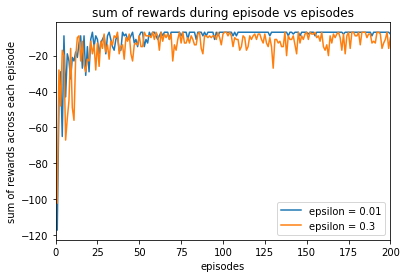

In [151]:
plt.plot(np.arange(500)+1,r1,label = "epsilon = 0.01")
plt.plot(np.arange(500)+1,r2,label = "epsilon = 0.3")
plt.title("sum of rewards during episode vs episodes")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")
plt.xlim(0,200)
plt.legend(loc = "lower right")

For epsilon = 0.01 we observe a significant increase in the sum of rewards in the first 25 episodes with oscillations. The oscillations then decrease and the sum of rewards plateaus at a value near -7 with oscillations. 

As epsilon is increased these oscillations become larger and more erratic for higher episodes which can be seen above when observing the epsilon = 0.3 line.

In [152]:
########## Function to find route from start to goal depending on Q ###############

def findroute(Q,world):
    slist = [world.start] #path of states from start to end
    s = world.start #current state where the 4 Q values are being evaluated in the while statement below
    c = 0
    while s != world.goal:
        action = np.where(Q[:,s] == np.max(Q[:,s]))
        [(snew, reward)] = world.state_action_state(s=s, a=action[0][0])
        slist.append(snew)
        s = snew
        c = c + 1
        if c > 200:
            print("No solution found")
            return
        
    print(world.print_solution(S=slist))

In [164]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
Q = np.zeros((len(world.actions),len(world.states)))

a = 0.4
episodes = 500
eps = 0
Q, r = sarsa(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
eps = 0.001
Q, r = sarsa(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
eps = 0.01
Q, r = sarsa(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
eps = 0.1
Q, r = sarsa(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
eps = 0.4
Q, r = sarsa(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

solution for epsilon = 0
Solution:
+-+-+-+-+-+
|S|*|*|*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

solution for epsilon = 0.001
Solution:
+-+-+-+-+-+
|S|*|*|*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

solution for epsilon = 0.01
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*|*|*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|G|
+-+-+-+-+-+

solution for epsilon = 0.1
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*|*|*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+

solution for epsilon = 0.4
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



Upon multiple runs, I observe the path taken to be more random for higher epsilon values and more consistent for smaller epsilon values. Epsilon = 1 would completely ignore the argmax and choose a random action every time. We see epsilon = 0.001 sometimes follow the same path as epsilon = 0 but epsilon = 0.1 and 0.4 almost never follow the same path due to the random action being triggered a lot within the epsilon-greedy policy.

## 3. Q-learning 
SARSA is called an "on-policy" algorithm, because it makes assumptions on what the action that the policy will make at the next step to estimate $Q$. Therefore, the value function is dependent on the policy! 
$Q$-learning takes an alternative view, so-called "off-policy", where the value of a state-action pair is independent on the policy's actions, and is instead dependent on <i>the best possible course of action thereafter</i>. This is achieved by amending the update function: 
    $$
	Q^{(t+1)}(S_t,A_t)\leftarrow Q^{(t)}(S_t,A_t)+\alpha\left[
	R_{t+1} + \gamma \max_a Q^{(t)}(S_{t+1},a)-Q(S_t,A_t)
	\right]
	$$
    
In this part, you will:

a. implement the off-policy Q-learning algorithm and use it to solve the problem. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
c. C Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>

In [154]:
def Qlearn(world,a,Q,episodes,eps):
    r = np.zeros(episodes)
    for i in np.arange(episodes):
        s = world.start #  starts at start
        while s != world.goal:
            action = greedy(world,s,eps,Q)  #  Decided action based on greedy policy 
            [(snew, reward)] = world.state_action_state(s=s, a=action)  #  Finds new state based on taking said action
            Q[action,s] = Q[action,s] + a*(reward + world.gamma*np.max(Q[:,snew]) - Q[action,s])
            #  Implements update function
            s = snew
            r[i] += reward
    return Q, r



In [155]:
a = 0.4
episodes = 500
eps = 0.01
eps2 = 0.3
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
Qinput = np.zeros((len(world.actions),len(world.states)))
Q1, r1 = sarsa(world,a,Qinput,episodes,eps)
Qinput = np.zeros((len(world.actions),len(world.states)))
Q2, r2 = Qlearn(world,a,Qinput,episodes,eps2)

(0, 200)

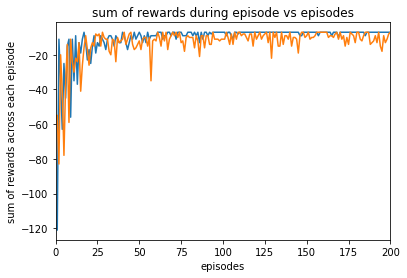

In [156]:
plt.plot(np.arange(episodes)+1,r1, label = "epsilon = 0.01")
plt.plot(np.arange(episodes)+1,r2, label = "epsilon = 0.3")

plt.title("sum of rewards during episode vs episodes")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")
plt.xlim(0,200)

For epsilon = 0.01, we observe a significant increase in the sum of rewards with a significant decrease in oscillations as the sum of rewards plateaus at -7. We observe similar behaviour as the SARSA algorithm where the sum of rewards experiences more erratic oscillations as epsilon is increased due to the random effect in the epsilon-greedy policy.

In [165]:

Q = np.zeros((len(world.actions),len(world.states)))
a = 0.1
episodes = 500
eps = 0
Q, r = Qlearn(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
a = 0.1
episodes = 500
eps = 0.001
Q, r = Qlearn(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
a = 0.1
episodes = 500
eps = 0.01
Q, r = Qlearn(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
a = 0.1
episodes = 500
eps = 0.1
Q, r = Qlearn(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)

Q = np.zeros((len(world.actions),len(world.states)))
a = 0.1
episodes = 500
eps = 0.4
Q, r = Qlearn(world,a,Q,episodes,eps)
#print(Q.T)
print("solution for epsilon =",eps)
findroute(Q,world)


solution for epsilon = 0
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+

solution for epsilon = 0.001
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*|*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+

solution for epsilon = 0.01
Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*|*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

solution for epsilon = 0.1
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*|*|G|
+-+-+-+-+-+

solution for epsilon = 0.4
Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+



Similarly we see the path taken upon multiple iterations be more random for higher epsilon values which is expected as the random action within the epsilon-greedy policy will be triggered more frequently for higher epsilon values. 

Finally, compare the two algorithms on a number of gridworld configurations (see examples below, but generate a few of your own) and discuss the results. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [158]:

######Initialising Gridworlds########
world1 = GridWorld(10,10, gamma=0.99, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
print(world1.tostring())

cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
       
world2 = GridWorld(10,10, gamma=0.99, start=[9,0], goal=[0,9], cliff=cliff)
print(world2.tostring())

world3 = GridWorld(10,10, gamma=0.99, start=[0,0], goal=[0,9], cliff=[[0,1], [1,2], [2,1], [3,2], [4,1], [5,2], [6,1],
                                                                     [7,2],[8,1],[8,4],[7,5],[6,4],[5,5],[4,4],[3,5],[2,4]
                                                                    ,[1,5],[9,5],[0,8],[1,7],[2,8],[3,7],[4,8],[5,7],[6,8],[7,7]])
print(world3.tostring())

world4 = GridWorld(10,10, gamma=0.99, start=[0,0], goal=[0,9], cliff=[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[2,1],[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8]])
print(world4.tostring())

Grid world:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+

Grid world:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+

Grid world:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | 

SARSA
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*| | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| |*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*| | |
+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | |*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |*| |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | |*|*| | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*| | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*|*|*|G|
+-+-+-+-+-+-+-+-+-+-+

Q-Learning
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+



Text(0, 0.5, 'sum of rewards across each episode')

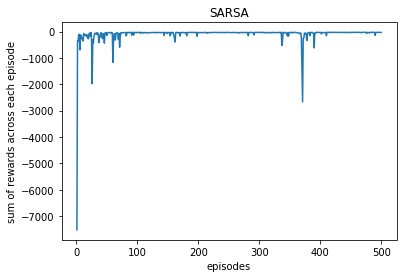

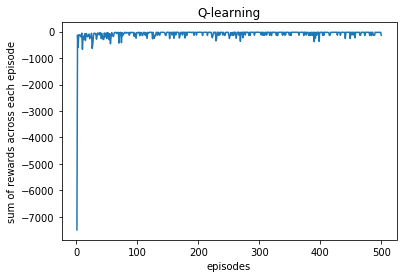

In [170]:
a = 0.4
episodes = 500
eps = 0.1
Q = np.zeros((len(world1.actions),len(world1.states)))
print("SARSA")
Qend, rs = sarsa(world1,a,Q,episodes,eps)
findroute(Qend,world1)
Q = np.zeros((len(world1.actions),len(world1.states)))
print("Q-Learning")
Qend, rq = Qlearn(world1,a,Q,episodes,eps)
findroute(Qend,world1)

plt.figure()
plt.plot(np.arange(episodes)+1,rs)
plt.title("SARSA")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

plt.figure()
plt.plot(np.arange(episodes)+1,rq)
plt.title("Q-learning")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

Q-Learning takes the fastest route as SARSA will take a safer route depending on epsilon. The higher epsilon the safer the route sarsa takes as shown above where epsilon is quite large and maintains a distance from the cliffs unlike the Q-learning method which does not and retrieves an optimal path.

I observe the SARSA spike a lot more than Q-learning which is due to a route being harder to find in each episode for SARSA than Q-learning. This is because SARSA leaves room for exploration which will cause it to sometime take longer to converge to the 'goal' thereby causing a spike.

SARSA
Solution:
+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*|*|*|*|*|S|
+-+-+-+-+-+-+-+-+-+-+
| | |*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*|*|*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+

Q-Learning
Solution:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*|*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+



Text(0, 0.5, 'sum of rewards across each episode')

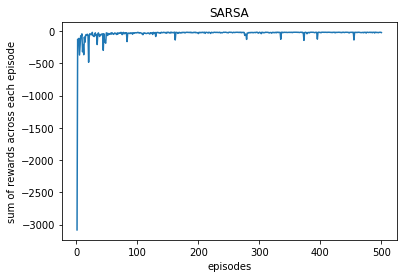

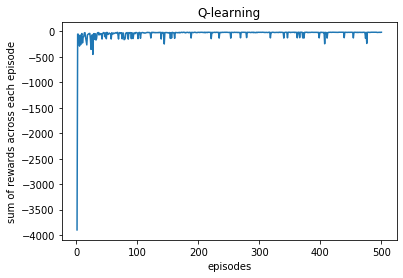

In [173]:
a = 0.4
episodes = 500
eps = 0.1
Q = np.zeros((len(world2.actions),len(world2.states)))
print("SARSA")
Qend, rs = sarsa(world2,a,Q,episodes,eps)
findroute(Qend,world2)
Q = np.zeros((len(world2.actions),len(world2.states)))
print("Q-Learning")
Qend, rq = Qlearn(world2,a,Q,episodes,eps)
findroute(Qend,world2)

plt.figure()
plt.plot(np.arange(episodes)+1,rs)
plt.title("SARSA")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

plt.figure()
plt.plot(np.arange(episodes)+1,rq)
plt.title("Q-learning")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

Again we observe SARSA take a safer route not going near the cliff but the Q-learning will take an optimal path regardless of how close to the cliffs it gets. *(Sometimes they'll both not go near the cliff or vice versa however the statement occurs most of the time upon multiple runs)*

This is because of the on-policy/off-policy difference between the 2 algorithms where Q-learning will learn off of an estimate of the optimal policy by updating Q based on the largest action value of its next state where as SARSA will update Q based on the action it is going to take next off the current policy. 


SARSA
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
|X| |X| |X| |X| |X|*|
+-+-+-+-+-+-+-+-+-+-+
| |X| |X| |X| |X| |*|
+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |X| |X| |X| |
+-+-+-+-+-+-+-+-+-+-+
|*|X| |X| |X| |X| |X|
+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*|*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+
| |X| |X| |X| |X|*| |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| |X| |X| |*| |
+-+-+-+-+-+-+-+-+-+-+
|G|*|*|*|*|*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+

Q-Learning
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
|X| |X| |X| |X| |X|*|
+-+-+-+-+-+-+-+-+-+-+
| |X| |X| |X| |X| |*|
+-+-+-+-+-+-+-+-+-+-+
| |*|*|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
|*|*|X| |X| |X| |X| |
+-+-+-+-+-+-+-+-+-+-+
|*|X| |X| |X| |X| |X|
+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*|*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+
| |X| |X| |X| |X|*| |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| |X| |X| |*| |
+-+-+-+-+-+-+-+-+-+-+
|G|*|*|*|*|*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+



Text(0, 0.5, 'sum of rewards across each episode')

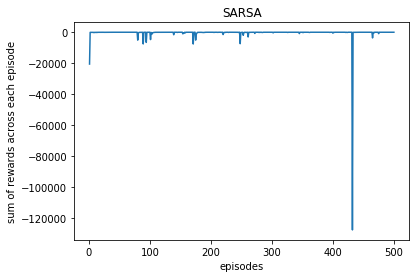

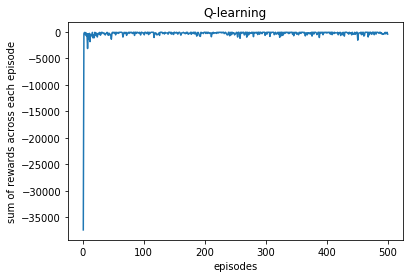

In [161]:
a = 0.4
episodes = 500
eps = 0.01
Q = np.zeros((len(world3.actions),len(world3.states)))
print("SARSA")
Qend, rs = sarsa(world3,a,Q,episodes,eps)
findroute(Qend,world3)
Q = np.zeros((len(world3.actions),len(world3.states)))
print("Q-Learning")
Qend, rq = Qlearn(world3,a,Q,episodes,0.1)
findroute(Qend,world3)

plt.figure()
plt.plot(np.arange(episodes)+1,rs)
plt.title("SARSA")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

plt.figure()
plt.plot(np.arange(episodes)+1,rq)
plt.title("Q-learning")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

I use a small epsilon as any larger causes the SARSA to not(or take long to) converge on a solution for an episode. This is because the world has a specific path and only has little room for exploration by the SARSA method. The Q-learning algorithm evaluates a lot of actions in the first episode hence the large value at the start but then requires little updating as Q has the best path calibrated and rarely takes random actions due to the low epsilon.

SARSA
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| | | |*|*| | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| | | | |*| | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| | | |*|*| | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X| |X| |*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
|G|*|*|*|*| | | | | |
+-+-+-+-+-+-+-+-+-+-+

Q-Learning
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*| | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|G|*| | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+



Text(0, 0.5, 'sum of rewards across each episode')

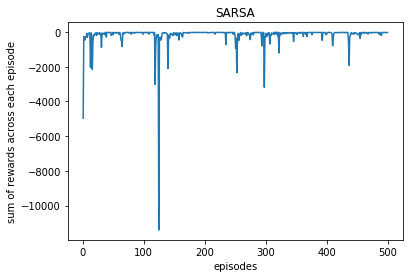

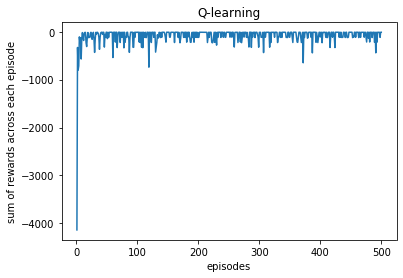

In [175]:
a = 0.4
episodes = 500
eps = 0.1
Q = np.zeros((len(world4.actions),len(world4.states)))
print("SARSA")
Qend, rs = sarsa(world4,a,Q,episodes,eps)
findroute(Qend,world4)
Q = np.zeros((len(world4.actions),len(world4.states)))
print("Q-Learning")
Qend, rq = Qlearn(world4,a,Q,episodes,0.1)
findroute(Qend,world4)

plt.figure()
plt.plot(np.arange(episodes)+1,rs)
plt.title("SARSA")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

plt.figure()
plt.plot(np.arange(episodes)+1,rq)
plt.title("Q-learning")
plt.xlabel("episodes")
plt.ylabel("sum of rewards across each episode")

We see that Q-learning learns the optimal policy as SARSA will take a safer route as before as room is given to explore other routes which is clearly shown based on the structure of the world above which has 2 types of paths, 1 through a dangerous tunnel or outside the tunnel with lots of room for error.

Again we observe huge spikes in the SARSA which takes place when a route cannot be found on a specific episode due to the route continously hitting a cliff. SARSA will generally avoid an optimal path if its dangerous like in the world above. Q-learning has more consistent spikes as the optimal path it takes can be percieved as consistently dangerous throughout the path.
